**IMPORTS**

In [70]:
import os
import math
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from scipy.signal import butter, lfilter
import soundfile as sf

**VARIABLES GLOBALES**

In [71]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
audios           = {fruit: [] for fruit in fruit_types}
training_path    = '../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

**DICCIONARIO DE AUDIOS ORIGINALES**

In [72]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**DICCIONARIO DE AUDIOS PROCESADOS**

In [73]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**PARAMETROS DEL AUDIO**

In [74]:
FRAME_SIZE = 512# In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

**FUNCIONES GENERALES DE AUDIO**

In [75]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

**FILTERS**

In [76]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

**PRROCCESSING OF THE AUDIO FILES FUNCTIONS**

In [77]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

In [78]:
def process(audio_in, audio_out, rms_umbral = 0.043, flux_umbral = 0.096):
    signal, sr, _ = load_audio(audio_in)

    rms = librosa.feature.rms(y = signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)
    rms /= np.max(np.abs(rms))
    trms = librosa.times_like(rms, sr = sr, hop_length = HOP_SIZE, n_fft = FRAME_SIZE)
    trms /= trms[-1]

    flux = spectral_flux(signal)
    flux /= np.max(np.abs(flux))
    fluxframes = range(len(flux))
    tflux = librosa.frames_to_time(fluxframes, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
    tflux /= tflux[-1]
                
    left_index = np.argmax(np.abs(flux) > flux_umbral)
    rigth_index = len(flux) - 1 - np.argmax(np.abs(np.flip(flux)) > flux_umbral)

    tsignal = librosa.times_like(signal, sr = sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    tsignal /= tsignal[-1]

    flag      = False
    pad_left  = 0
    pad_rigth = 0
    flag_left  =  False
    flag_rigth =  False
                
    while not flag:
        if rms[0, left_index] > rms_umbral:
            if left_index > pad_left + 15:
                rms_left = left_index - np.argmax(np.flip(np.abs(rms[0, :left_index]) < rms_umbral))
                if rms_left <= 0:
                    rms_left = left_index
                flag_left = True
            else:
                pad_left += 15
                left_index = pad_left + np.argmax(np.abs(flux[pad_left:]) > flux_umbral)
        else:
                rms_left = left_index
                flag_left = True

        if rms[0, rigth_index] > rms_umbral:
            if rigth_index < (len(flux) - 1 - pad_rigth-15):
                rms_rigth = rigth_index + np.argmax(np.abs(rms[0, rigth_index:]) < rms_umbral)
                if rms_rigth >= len(flux):
                    rms_rigth = rigth_index
                flag_rigth = True
            else:
                pad_rigth += 15
                rigth_index = len(flux[:-pad_rigth]) - 1 - np.argmax(np.flip(np.abs(flux[:-pad_rigth]) > flux_umbral))                               
        else:
            rms_rigth = rigth_index
            flag_rigth = True

        flag = flag_left and flag_rigth

    left_index  = min(left_index, rms_left)
    rigth_index = max(rigth_index, rms_rigth)

    mask = tsignal >= tflux[left_index]
    ttrimed = tsignal[mask]
    trimed = signal[mask]
    mask = ttrimed <= tflux[rigth_index]
    ttrimed = ttrimed[mask]
    trimed = trimed[mask]
    sf.write(audio_out, trimed, sr)

In [79]:
def process_audios(original:dict, processed:dict):
    already_processed = []
    for group in processed.values():
        already_processed.extend([os.path.basename(audio) for audio in group])
        
    for fruit, audios in original.items():
        for audio in audios:
            file = os.path.basename(audio)
            if file in already_processed:
                pass
            else:
                audio_out = os.path.join(processed, f"{fruit}/{file}")
                process(audio, audio_out)
                processed[fruit].append(audio_out)

**PLOTTING**

In [80]:
#3d
def plot_features3d(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

**AUDIO PROCESSING**

In [81]:
process_audios(original, processed)

**FEATURES EXTRACTION**

*Features extraction functions*

In [82]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [83]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [84]:
def rms(signal, frames, hop):
    return librosa.feature.rms(y=signal, frame_length = frames, hop_length = hop)

*function to get the features*

In [85]:
def get_features(signal, sr):
    feature = np.empty((1, 0))

    # BER
    spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    # max
    split_frequency = 600
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.max(np.abs(BER))
    feature = np.append(feature, feat)
    # min
    # 1
    split_frequency = 1900
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 5000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 3
    split_frequency = 9000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # std
    # 1
    split_frequency = 8000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 1000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)

    #ZCR
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    # mean
    feat = np.mean(zcr)
    feature = np.append(feature, feat)
    # maximum
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(np.abs(zcr))
    feature = np.append(feature, feat)
    # std
    cutoff = 10000
    cuton  = 20
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.std(zcr)/np.mean(np.abs(zcr))
    feature = np.append(feature, feat)
    # mean local
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    feat = np.mean(zcr[((len(zcr)*3)//14 - 5) : ((len(zcr)*3)//14 + 5)])
    feature = np.append(feature, feat)
    # local max
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(zcr[((len(zcr)*3)//4 - 10) : ((len(zcr)*3)//4 + 10)])
    feature = np.append(feature, feat)

    # Roll off
    cuton = 100
    cutoff = 8500
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    # mean
    feat = np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)
    # max
    cuton = 100
    cutoff = 8500
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.55)[0]
    feat = np.max(np.abs(roll_off))
    feature = np.append(feature, feat)
    # std
    cutoff = 8500
    cuton = 50
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    feat = np.std(np.abs(roll_off))/np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)

    #MFCCS
    n_mfcc = 4
    # 1
    cuton = 500
    cutoff = 5000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.max(mfccs, axis = 1)
    feature = np.append(feature, feat[3])
    
    # 2
    cuton = 10
    cutoff = 8000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    feat = np.std(np.abs(mfccs), axis = 1)/np.mean(np.abs(mfccs), axis = 1)
    feature = np.append(feature, feat[3])

    # 3
    cuton = 10
    cutoff = 8000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    mfccs = mfccs[:, ((mfccs.shape[1]*4) // 5 - 10):((mfccs.shape[1]*4) //5 + 10)]
    feat = np.std(np.abs(mfccs), axis=1) / np.mean(np.abs(mfccs), axis=1)
    feature = np.append(feature, feat[1])

    #envelope
    env = rms(signal, FRAME_SIZE, HOP_SIZE)
    env = env.reshape(-1,)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature

**EXTRACTION OF FEATURES FROM PROCESSED AUDIOS**

In [86]:
def extract_features(processed:dict):
    features = dict.fromkeys(fruit_types)
    for fruit, audios in processed.items():
        features[fruit] = None
        
        for audio in audios:
            # Load the audio signal
            signal, sr, _ = load_audio(audio)
            feature = get_features(signal, sr)
        
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    return features

**TRAINING AUDIOS FEATURES EXTRACTION**

In [87]:
features = extract_features(processed)

C:\Users\Juan\AppData\Local\Temp\ipykernel_3228\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)
c:\Users\Juan\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


**PCA**

In [88]:
#PCA and dump
whole            = np.concatenate(list(features.values()), axis=0)

#Aplicar PCA para obtener dos componentes principales
pca              = PCA(n_components = 3)
scaler           = StandardScaler()
whole_scaled     = scaler.fit_transform(whole)
reduced_features = pca.fit_transform(whole_scaled)

**REDUCED MODEL**

In [89]:
#Paso 3: Crear un diccionario con las matrices reducidas
reduced = {}
start_idx = 0

for fruit, matrix in features.items():
    num_rows = matrix.shape[0]
    reduced[fruit] = reduced_features[start_idx:start_idx + num_rows, :]
    start_idx += num_rows

**DUMPING TO FILE**

In [90]:
model['pca']      = pca
model['features'] = reduced
model['scaler']   = scaler
joblib.dump(model, model_file)

['model.pkl']

**PLOTTING**

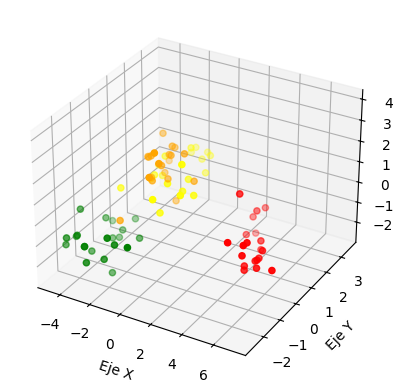

In [91]:
plot_features3d(reduced)